# CMPINF 11 Final Project: Finding the best neighborhood in Pittsburgh
Group Members: Nicholas Hoffman, Jared Russman, Alex Jin

In [1]:
!pip install pandas numpy matplotlib scipy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

zsh:1: command not found: pip


## Introduction
Hello! We are team – Named Last Minute and we believe that we have found the best neighborhood in Pittsburgh. We eventually chose the best infrastructure as our metric for what makes a neighborhood the greatest in our city. Initially we thought of doing healthiness, then considered something to do with the cost of living, but finally settled on infrastructure, because a lot of different things can be considered infrastructure.

## Infrastructure: Parks - Nicholas Hoffman
For my sub-metric I chose the one of the most important pieces of infrastructure to me: parks — since I like to hike. Parks are great stress relief, they remove yourself from the hustle and bustle of city life, and are great places to have social gatherings, as well as making the environment way nicer with greenery and fresh air. 

### Data Set
I am using the data set simply called [Pittsburgh Parks](https://data.wprdc.org/datastore/dump/bb57d0a7-e8ee-4218-8906-0dedc903038c).

In [2]:
pgh_parks_data = pd.read_csv("https://data.wprdc.org/datastore/dump/bb57d0a7-e8ee-4218-8906-0dedc903038c") # index_col = "sector"
# pgh_parks_data.info()

The more park the merrier (especially when it comes to hiking), so the feature I honed in on was the overall area in square feet of parks in each neighborhood. The parks were not separated into neighborhoods, however, but 16 sectors, so I had to map those to specific neighborhoods. I eliminated bottom 6 sectors immediately (to get a clean top 10). I did not divide the parks in any way, I know some parks are in multiple neighborhoods but they fell in the one they were in the most. Also, some things are similar to parks but are not in the data base, like the Allegheny Cemetery.

The neighborhood with the most square footage of parks in it was **Squirrel Hill** by a landslide. Which is not surprising if you consider that two of the largest Parks, Schenley and Frick Park were considered in Squirrel Hil. The next couple of neighborhoods were also buoyed by singular massive parks, as number 2 was Hays, with Hays Woods, and 3 was Highland Park, with Highland Park. Mount Washington and Beechview had more spread-out smaller parks at 4 and 5.  

I grabbed the park data but it has way more information that I need, I just care about how the square footage of park per sector. So I group by the sector as an index and the sum of the sqft in each sector

In [3]:
sector_sqft = pgh_parks_data.groupby("sector")["sqft"].sum().sort_values(ascending=False)
print("after grouping:")
print(sector_sqft.head(5))

after grouping:
sector
10.0    4.703252e+07
8.0     2.885870e+07
12.0    1.836450e+07
6.0     1.522724e+07
5.0     1.393727e+07
Name: sqft, dtype: float64


### Making the Data Nicer
Thats a lot easier to deal with, but it is still hard to parse. 
First, I cut out the top 10 because we do not care about the lowest 6, then I had to find out what the sectors meant.
Every sector is roughly a neighborhood, and so I went on google maps satellite view as well as looking at the map that I gathered the original data for the parks from. I then filtered by sector to find all the parks in a sector and matched it to it’s neighborhood. Then I replaced the sector numbers with the neighborhood names and made the data more readable by converting the large numbers of square feet into millions of square feet.

In [4]:
# then get the top 10 only
top_10 = sector_sqft.head(10)
# then add the name of the neighborhoods associated with the sector
names = ["Squirrel Hill", "Hays", "Highland Park", "Mount Washington", "Beechview", "Perry North", "Hazelwood", "Sheriden", "South Side", "Allegheny Center"]
top_10.index = names 
#then make the data more readable but making it be in the millions of squarefeet
top_10 = top_10/1_000_000
print(top_10)

Squirrel Hill       47.032516
Hays                28.858705
Highland Park       18.364503
Mount Washington    15.227244
Beechview           13.937272
Perry North         13.586878
Hazelwood            7.190135
Sheriden             5.155440
South Side           4.458995
Allegheny Center     3.309189
Name: sqft, dtype: float64


Now I just made it into a bar graph.

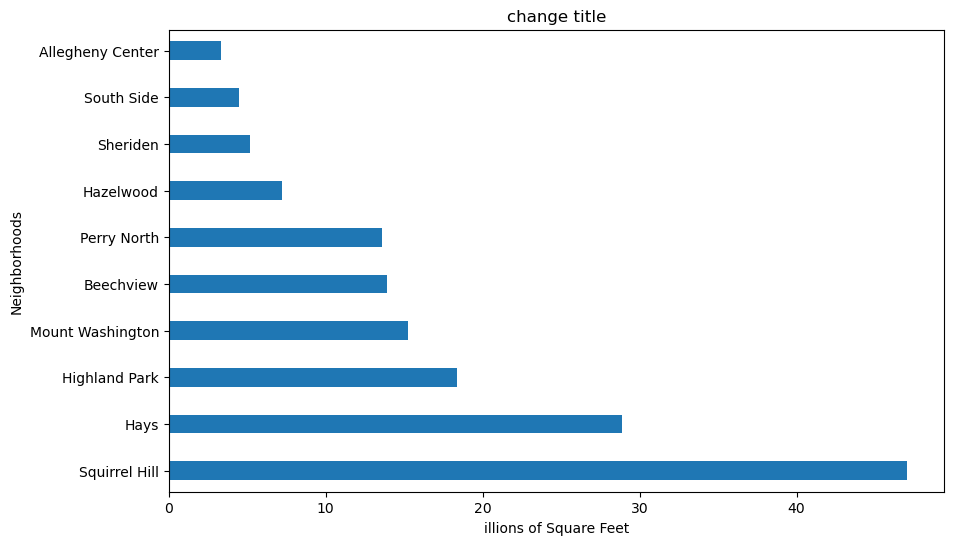

In [5]:
top_10.plot(kind ="barh", width = 0.4, figsize=(10, 6))
plt.title("change title")
plt.xlabel("illions of Square Feet")
plt.ylabel("Neighborhoods")
plt.show()

## Transit: On Time Performance (OTP) - Alex Jin
Since most commuter’s way of travel will be via bus (especially university students), it is essential for them to be on time, so commuters can schedule accordingly and not arrive later, or too early than they are supposed to. This dataset collects the "on time performance" percentage of each route; which is the "fraction of timepoints that the transit vehicle departed on time from the stop", according to the data dictionary.

By categorizing each route into a neighborhood, we can analyze which neighborhood has the highest on time performance.

### Gathering Data and Filtering
I am using the dataset provided [here](https://data.wprdc.org/dataset/port-authority-monthly-average-on-time-performance-by-route/resource/00eb9600-69b5-4f11-b20a-8c8ddd8cfe7a), which is licensed under CC-BY.

I am using only data from weekday services, excluding weekends and special dates (Christmas, Memorial Day, etc). I am also using data starting since 2024-01, so it is the most recent.

In [6]:
otp_dataset = pd.read_csv("https://data.wprdc.org/datastore/dump/00eb9600-69b5-4f11-b20a-8c8ddd8cfe7a")
otp_dataset["month_start"] = pd.to_datetime(otp_dataset["month_start"])
weekday_otp = otp_dataset\
    [(otp_dataset["year_month"] >= 202401) & (otp_dataset["day_type"] == "WEEKDAY")]\
    .drop("ridership_route_code", axis=1)\
    .drop("data_source", axis=1)
# weekday_otp.info()

### Categorizing Routes
Since the dataset does not have a column for the neighborhood it goes through, I manually created keywords to categorize different routes by name into neighborhoods.

For convenience of coming to the conclusion of the best neighborhood, I also used the same list of neighborhood by the previous metric; that is:

In [7]:
keywords = {
    "Squirrel Hill": ["SQUIRREL HILL"],
    "Hays": ["LINCOLN PLACE"],
    "Highland Park": ["HIGHLAND PARK"],
    "Mount Washington": ["MOUNT WASHINGTON"],
    "Beechview": ["BEECHVIEW"],
    "Perry North": ["PERRYSVILLE"],
    "Hazelwood": ["HAZELWOOD"],
    "Sheriden": ["CHARTIERS", "FAIRYWOOD"],
    "South Side": ["SOUTH SIDE"],
    "Allegheny Center": ["NORTH SIDE"]
}

Then, I wrote a small helper function to help categorize different routes with the dictionary.

In [8]:
def get_neighborhood(route_name):
    route_upper = str(route_name).upper()
    for hood, keys in keywords.items():
        for key in keys:
            if key in route_upper:
                return hood
    pass

Finally, after categorizing each route into a neighborhood, I can calculate the average OTP for each neighborhood.

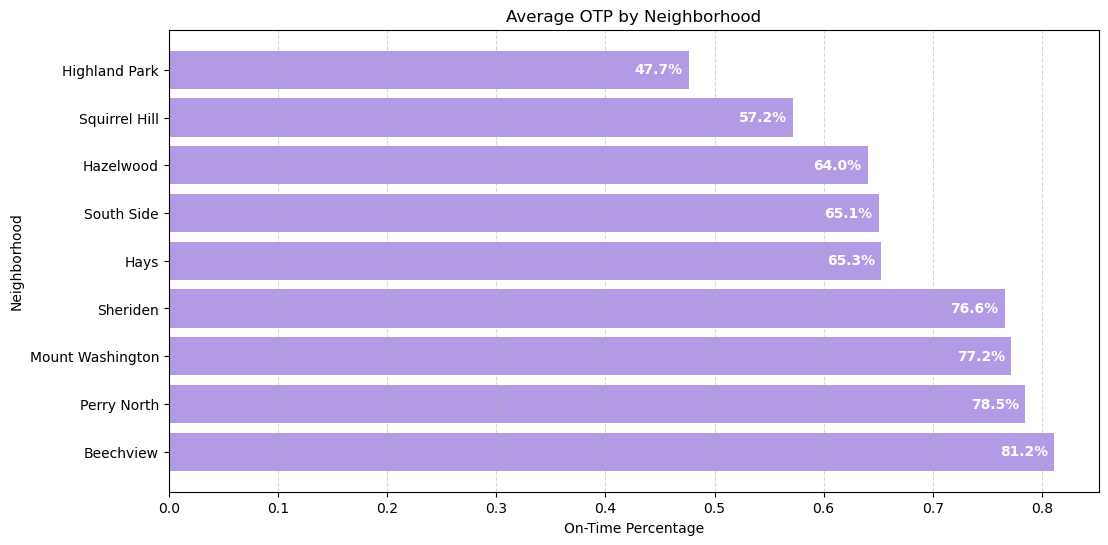

In [9]:
weekday_otp["assigned_neighborhood"] = weekday_otp["route_full_name"].apply(get_neighborhood) # applying the helper function
mapped_data = weekday_otp[weekday_otp["assigned_neighborhood"].notnull()] # filter with only matches
assignments = mapped_data[["route_full_name", "assigned_neighborhood"]].drop_duplicates().sort_values("assigned_neighborhood") # assigned routes to neighborhood
hood_stats = mapped_data.groupby("assigned_neighborhood")["on_time_percent"].mean().reset_index().sort_values("on_time_percent", ascending=False) # calculating metrics for these neighborhoods

# print("assignments:\n", assignments)
# print("\nperformance stats:\n", hood_stats)

plt.figure(figsize=(12, 6))
bars = plt.barh(hood_stats["assigned_neighborhood"], hood_stats["on_time_percent"], color="mediumpurple", alpha = 0.7)
plt.title("Average OTP by Neighborhood")
plt.xlabel("On-Time Percentage")
plt.ylabel("Neighborhood")
plt.grid(axis="x", linestyle="--", alpha=0.5)

# add OTP label in percentage
for bar in bars:
    width = bar.get_width()
    plt.text(width - 0.05, bar.get_y() + bar.get_height() / 2, f"{width:.1%}", va="center", fontsize=10, color="white", fontweight="bold")

plt.show()

From the chart, we can see that **Beechview** have the highest OTP for all the transit routes in that area.

### Extra: Graphs and Charts
Just for fun, I have created some extra visualizations. This one shows the average OTP over time, from 2017 to the data cutoff (later 2024).

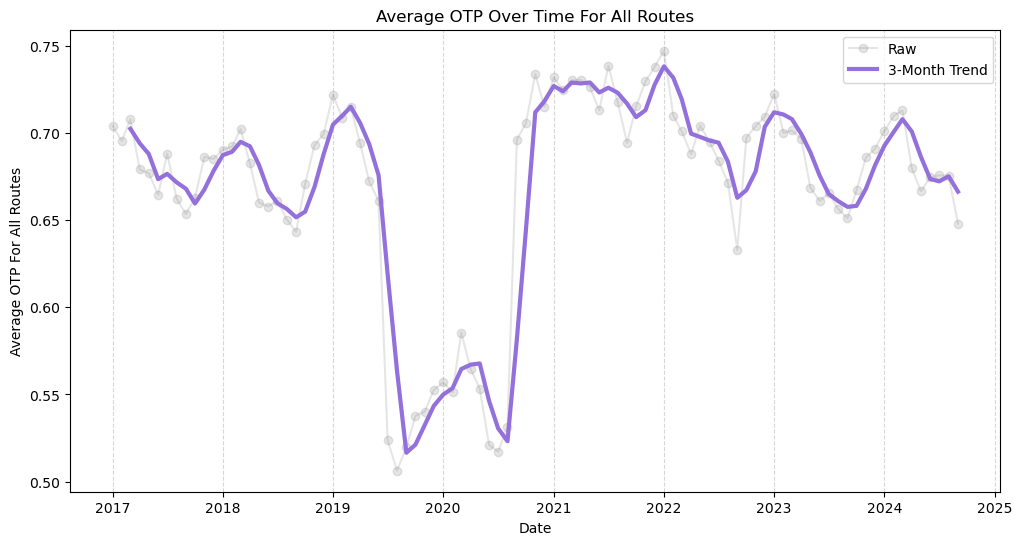

In [10]:
monthly_avg = otp_dataset.groupby("month_start")["on_time_percent"].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(monthly_avg["month_start"], monthly_avg["on_time_percent"], label="Raw", marker="o", linestyle="-", color="gray", alpha=0.2)
plt.title("Average OTP Over Time For All Routes")
plt.xlabel("Date")
plt.ylabel("Average OTP For All Routes")
plt.grid(axis="x", linestyle="--", alpha=0.5)

monthly_avg["rolling_avg"] = monthly_avg["on_time_percent"].rolling(window=3).mean()
plt.plot(monthly_avg["month_start"], monthly_avg["rolling_avg"], linewidth=3, color="mediumpurple", label="3-Month Trend")

plt.legend()
plt.show()

This chart shows the top 10 most reliable routes — that is, having the highest OTP.

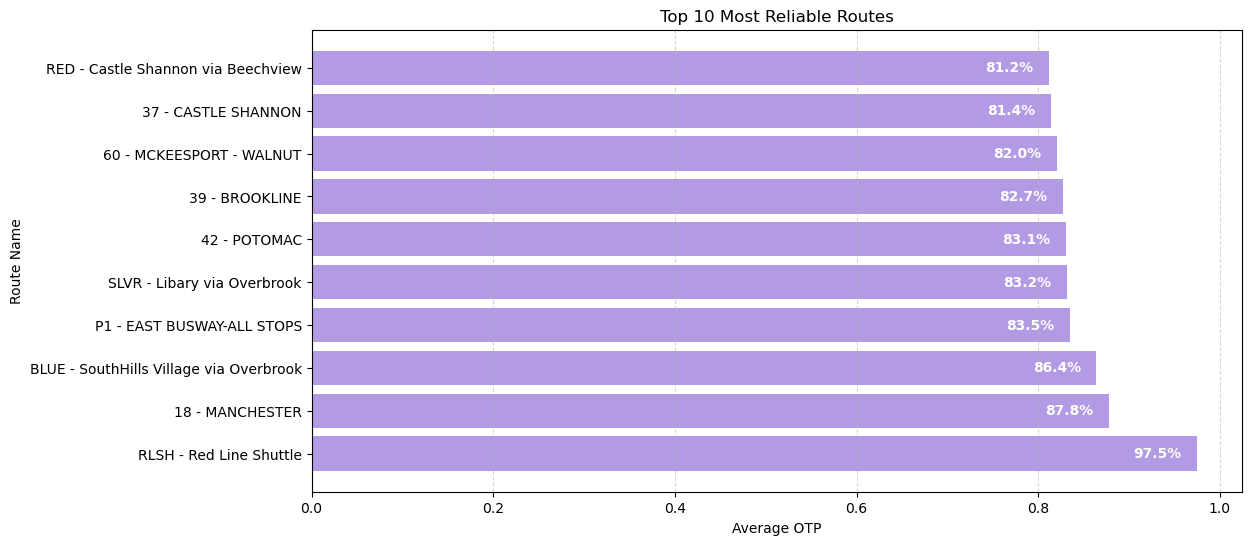

In [11]:
top10_routes = weekday_otp.groupby("route_full_name")["on_time_percent"].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
bars = plt.barh(top10_routes.index, top10_routes.values, color="mediumpurple", alpha=0.7)
plt.title("Top 10 Most Reliable Routes")
plt.xlabel("Average OTP")
plt.ylabel("Route Name")
plt.grid(axis="x", linestyle="--", alpha=0.5)

for bar in bars:
    width = bar.get_width()
    plt.text(width - 0.07, bar.get_y() + bar.get_height() / 2, f"{width:.1%}", va="center", fontsize=10, color="white", fontweight="bold")

plt.show()

This historgram shows the distribution of OTP over all routes. Since it is normalized already, we can see that it is actually a normal distribution! In addition to plotting the density, I also added a line that shows the normal distribution:

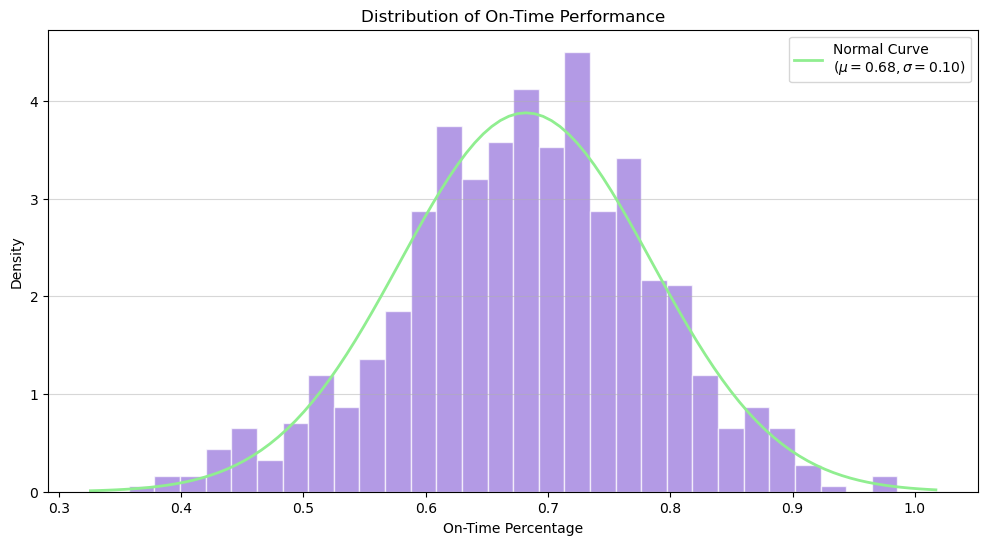

In [12]:
plt.figure(figsize=(12, 6))

# standard distribution
mu = weekday_otp["on_time_percent"].mean()
sigma = weekday_otp["on_time_percent"].std()

# plot
plt.hist(weekday_otp["on_time_percent"], density=True, bins=30, color="mediumpurple", edgecolor="white", alpha=0.7)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, linewidth=2, label=f"Normal Curve \n($\\mu={mu:.2f}, \\sigma={sigma:.2f}$)", color="lightgreen")
plt.legend()
plt.title("Distribution of On-Time Performance")
plt.xlabel("On-Time Percentage")
plt.ylabel("Density")
plt.grid(axis="y", alpha=0.5)
plt.show()

## Submetic: Dumpsites - Jared

For my submetric, I decided to continue with a dataset that's called Illegal Dump Sites. The data set contains all information based on illegal sites to dump trash, the type of trash being deposited, and the estimate tons of how much trash is at each of these sites. The neighborhood that has the cleanest environment from trash will be deemed the best.

The dataset can be found [here](https://data.wprdc.org/dataset/ed4cf849-d323-4d01-8a13-675d283f1ac9/resource/ee834d8d-ae71-4b3b-b02b-312ba321ff17/download/illegaldumpsites.csv).

### Taking The Data and Cleaning It Up

I am going to begin by cleaning by dataset off by grouping them by neighborhoods and the estimated tons. This way I will have all the sites in the neighborhoods and how much trash has been dumped there all together

In [13]:
dumpsites = pd.read_csv("https://data.wprdc.org/dataset/ed4cf849-d323-4d01-8a13-675d283f1ac9/resource/ee834d8d-ae71-4b3b-b02b-312ba321ff17/download/illegaldumpsites.csv")
dumpsites.head()

,site_name,Status,City,Neighborhood,estimated_tons,location_description,latitude,longitude,Unnamed: 8
0,St. Martin Street,Surveyed,Pittsburgh,Allentown,0.5,NaN,40.42221971,-79.99022525,NaN
1,Brosville Street,Surveyed,Pittsburgh,Allentown,3,NaN,40.42370101,-79.98657393,NaN
2,McCain Street,Surveyed,Pittsburgh,Allentown,1,NaN,40.42427063,-79.99022675,NaN
3,Ceres Way,Surveyed,Pittsburgh,Allentown,0.5,NaN,40.42327242,-79.99248958,NaN
4,Eureka Street,Completed,Pittsburgh,Allentown,0.1,NaN,40.42372131,-79.99478912,NaN


### Grouping My Neighborhoods

I am taking all the neighborhoods from my data sets and arranging them in a descending approach. This will help by organzing my data in order and it will provide easier access to see what neighborhood has the most sites

In [14]:
dumpsites.groupby('Neighborhood').count()

,site_name,Status,City,estimated_tons,location_description,latitude,longitude,Unnamed: 8
Neighborhood,,,,,,,,
Allentown,7,7,7,7,2,7,7,0
Arlington,9,9,9,9,0,9,9,0
Avalon,2,2,2,2,1,2,2,0
Banksville,1,1,1,1,0,1,1,0
Barking Slopes,2,2,2,2,2,2,2,0
...,...,...,...,...,...,...,...,...
Wilkins,3,3,3,3,0,3,3,0
Wilkins/Monroeville,1,1,1,1,0,1,1,0
Wilkinsburg,9,9,9,9,2,9,9,0


In [15]:
dumpsites.groupby('Neighborhood').count().loc[:,"site_name"]

Neighborhood
Allentown                 7
Arlington                 9
Avalon                    2
Banksville                1
Barking Slopes            2
                         ..
Wilkins                   3
Wilkins/Monroeville       1
Wilkinsburg               9
Wilkinsburg/Penn Hills    1
Windgap                   3
Name: site_name, Length: 152, dtype: int64

In [24]:
dumpsites_series = dumpsites.groupby('Neighborhood').count().loc[:,"site_name"].sort_values(ascending=False)

### Grouping By Estimated Tons

Now I am taking my neighborhoods data and finding out how much trash are in each of those areas. Cleaning the data up, once again, to make it easier to understand and it follows a consistent order.

In [17]:
dumpsites.groupby('Neighborhood').count().loc[:,"estimated_tons"]

Neighborhood
Allentown                 7
Arlington                 9
Avalon                    2
Banksville                1
Barking Slopes            2
                         ..
Wilkins                   3
Wilkins/Monroeville       1
Wilkinsburg               9
Wilkinsburg/Penn Hills    1
Windgap                   3
Name: estimated_tons, Length: 152, dtype: int64

In [22]:
dumpsite_series = dumpsites.groupby('Neighborhood').count().loc[:,"estimated_tons"].sort_values(ascending=False)
dumpsite_series

Neighborhood
Hazelwood           66
Perry South         51
Beltzhoover         36
Carrick             27
Greenfield          21
                    ..
Gibsonia             0
Harmarville          0
Natrona              0
Sewickley            0
To Be Determined     0
Name: estimated_tons, Length: 152, dtype: int64

### Charts and Graphs

This bar graph is being used to show how much estimated tons are in each neighborhood. The top of the chart beginning with the most trash and it starts doing down to the neighborhood that has the least trash.

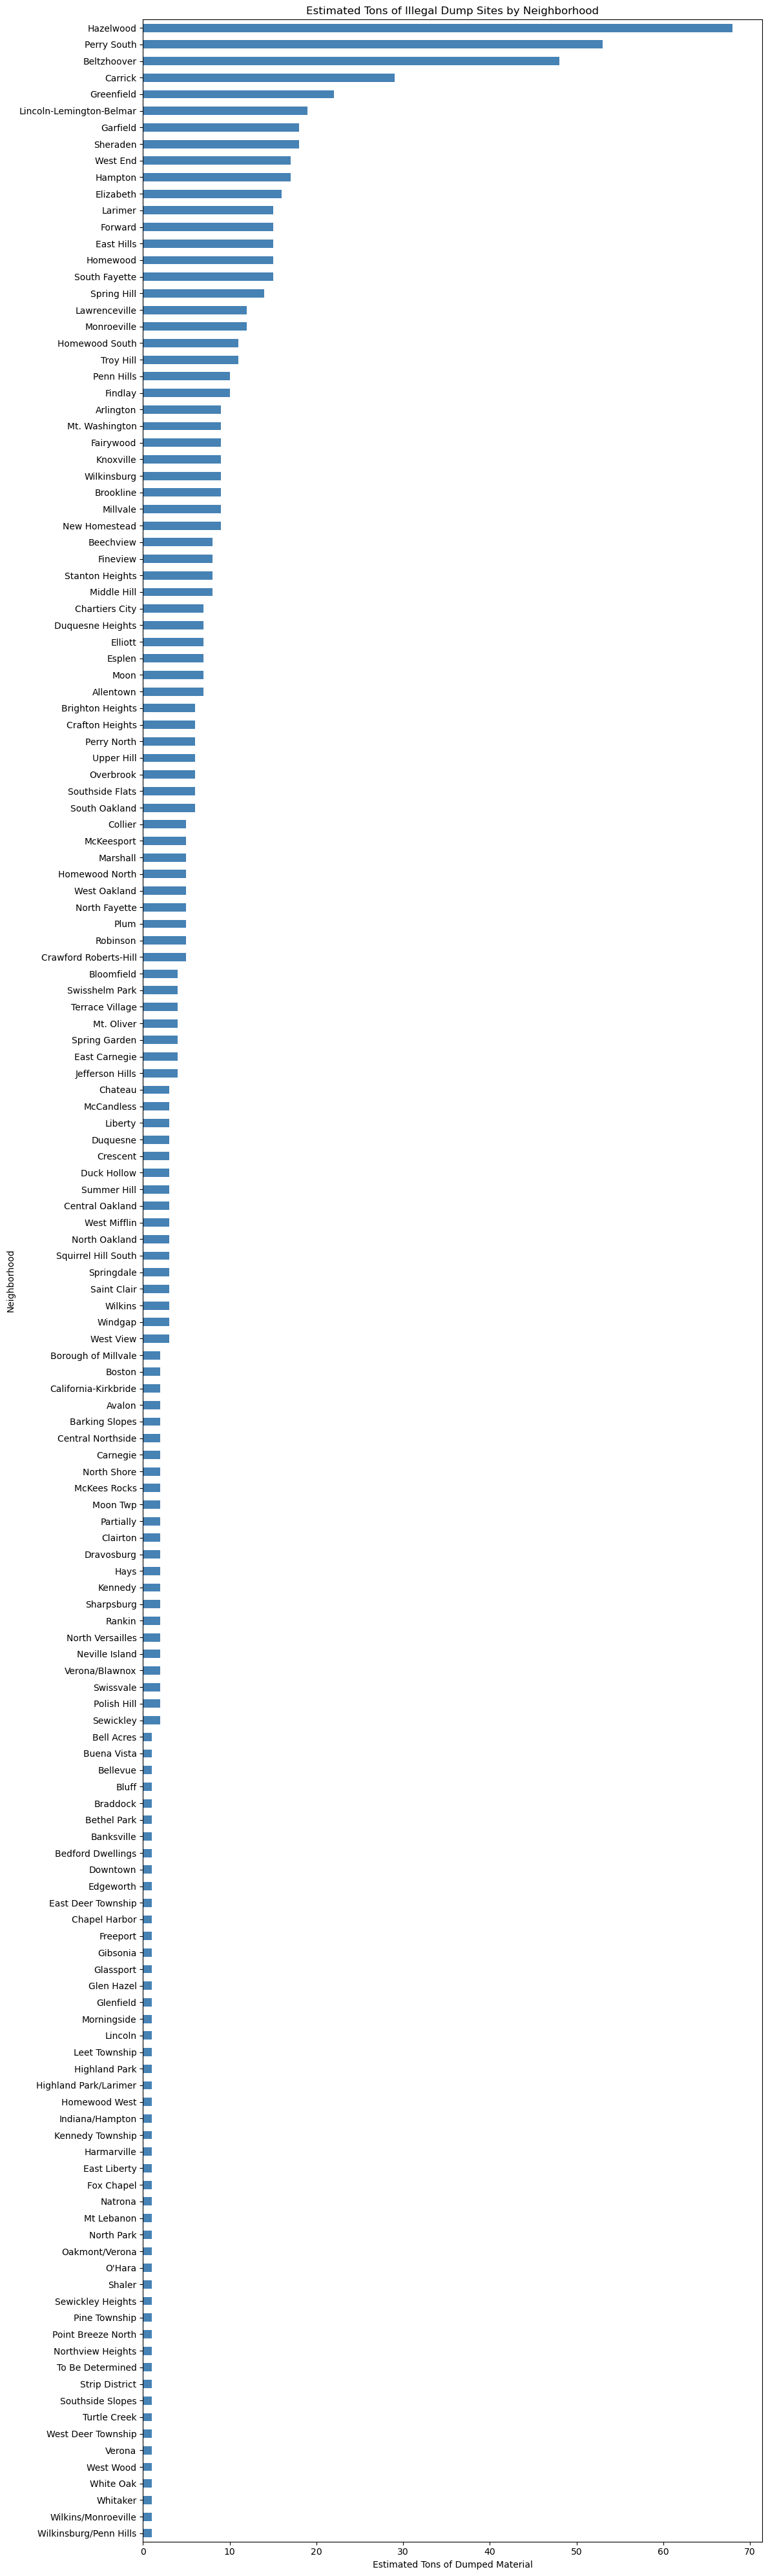

In [21]:
# Sort the data from highest to lowest estimated tons
sorted_series = dumpsites_series.sort_values(ascending=False)

# Set figure size to fit all neighborhoods
plt.figure(figsize=(12, 40))  # Tall figure for 152 neighborhoods

# Plot horizontal bar chart
sorted_series.plot.barh(color="steelblue")

# Labels and title
plt.xlabel("Estimated Tons of Dumped Material")
plt.ylabel("Neighborhood")
plt.title("Estimated Tons of Illegal Dump Sites by Neighborhood")

# Put the highest values at the top
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

## Conclusion: The Best Neighborhood

When you take everything into account and weight all three metrics, Hays is clearly the best neighborhood. The way we scored the neirghborhoods was a simple, best in submetric gets 10 points, second bets gets 9, etc, except for the garbage dumpin, for that we had to tie the lowest estimated tons dumped as the numbers (so the 1 ton estimated got 10 poits, the 2 ton got 9, etc). It scored very well with the second most park space and a very low amount of garbage dumped, overall scoring 23 points. The on time percentage was just okay but the execellent scores elsewhere put it at the top. This was a little surprising to me since I've never been to Hays, but the data doesnt lie. The Runner up, Squirrel Hill is more of what I would have expected, but it was dragged down by the being the second lowest on time percentage, scoring a total of 20 points.